In [1]:
#Evan Brown 
#Comparing dim reduce algs

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.manifold import TSNE
from sklearn.random_projection import SparseRandomProjection #from sklearn.random_projection import johnson_lindenstrauss_min_dim **rand proj to 2 or 3d unlikely to preserve sig amount variance as it will fall below reccomended min dim
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.manifold import MDS
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
import numexpr
dim_reduce_algs={
	#very fast, easily interpretable basis
	'pca' : PCA(n_components = 2),
	
	#good at unrolling twisted manifolds, esp. without much noise
	'lle' : LocallyLinearEmbedding(n_components=2),
	
	#good for very large datasets as it is extremely fast, and quality of dimensionality reduction depends only 	on the number of instances and the target dimensionality, not the initial dimenstionality. uses linear projections.
	'srp' : SparseRandomProjection(n_components=2),
	
	#tries to preserve distances between instances
	'mds' : MDS(n_components=2),
	
	#tries to preserve geodesic distances between instances
	'iso' : Isomap(n_components=2),
	
	#tries to keep similar instances close and dissimilar apart, mostly useful for visualization
	'tsne' : TSNE(n_components=2),
	
	#separates instances by class (actually a classification alg., most discriminative axes are learned in 	training and can be used to project instances onto for D reduction). Useful when reducing D for later 	classification alg.
	'lda' : LinearDiscriminantAnalysis(n_components=2)
}


n_algs = len(dim_reduce_algs)

#load data~~~~
wine = load_wine()
X, y = wine['data'], wine['target'] #remove secondary indexing for full data
X_train, X_test, y_train, y_test = train_test_split(X,y, train_size = 0.5)

#create lists of reduced Xs~~~~

#full
Xs_3d = np.empty(n_algs, dtype = 'object')
i=0
for alg in list(dim_reduce_algs.values()):
	Xs_3d[i] = alg.fit_transform(X,y)
	i += 1

#train
X_trains_3d = np.empty(n_algs, dtype = 'object')
i=0
for alg in list(dim_reduce_algs.values()):
	X_trains_3d[i] = alg.fit_transform(X_train, y_train)
	i += 1

#test
X_tests_3d = np.empty(n_algs, dtype = 'object')
i=0
for alg in list(dim_reduce_algs.values()):
	X_tests_3d[i] = alg.fit_transform(X_test,y_test)
	i += 1

#evaluate quality of D reduction~~~~
#1)calculate reconstruction error if inverse_transform exists
#2)then calculate  performance of all algs. with RandomForestClassifier, metric = mse

metrics = {
	'reconstruction_error':np.empty(n_algs),#(reconstruction error if avail
	'mse'	:np.empty(n_algs),				#mse on RFC
	'mse_devs_normalized':np.empty(n_algs) 			#mse deviations normalized to [-1,1] 
}
#reconstruction error (full set)
Xs_reconstructed = np.empty(n_algs, dtype = 'object')
i=0
for alg in list(dim_reduce_algs.values()):
	try:
		Xs_reconstructed[i] = alg.inverse_transform(Xs_3d[i])
		metrics['reconstruction_error'][i] = mean_squared_error(X, Xs_reconstructed[i])
	except AttributeError:
		metrics['reconstruction_error'][i]=np.nan
	i+=1
#mse on rfc(train rfc on train, eval on test)
rfc = RandomForestClassifier()
predictions_list = np.empty(n_algs, dtype = 'object')
i=0
for X_train in X_trains_3d:
	predictions = rfc.fit(X_train,y_train).predict(X_tests_3d[i])
	predictions_list[i]  =predictions
	metrics['mse'][i] = mean_squared_error(y_test, predictions)
	i += 1



mses = metrics['mse']


mses_0 = mses - np.mean(mses)
std = np.std(mses_0)
mses_std = mses_0 / std
scale = max(np.max(mses_std),np.min(mses_std))
mses_std_normal = mses_std / scale #mses standardized then normalized [-1,1]
metrics['mse_devs_normalized'] = mses_std_normal 





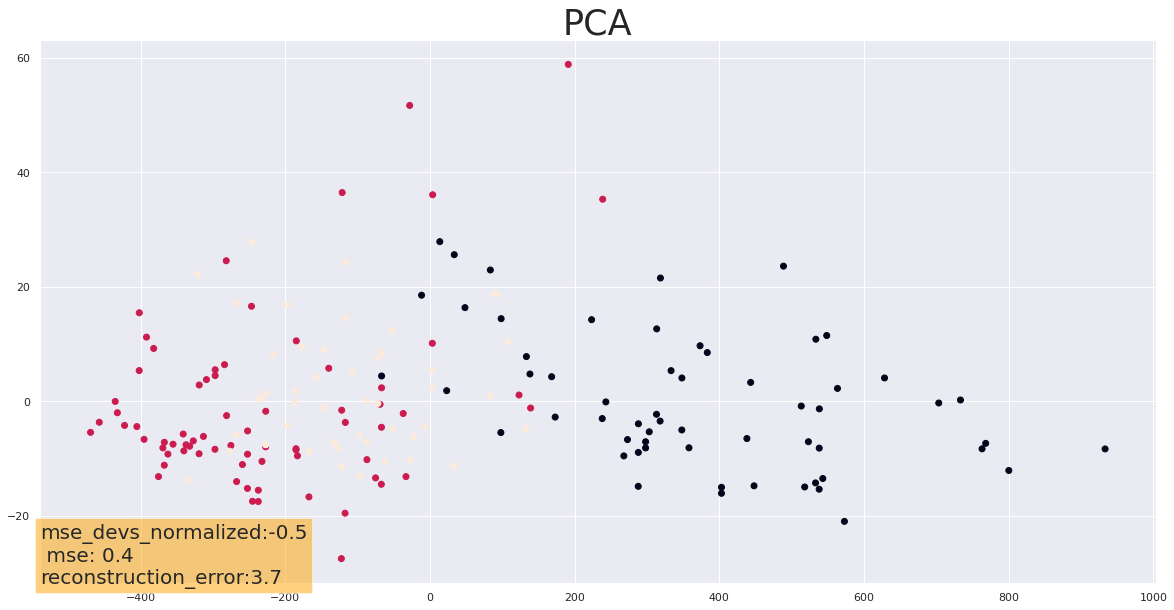

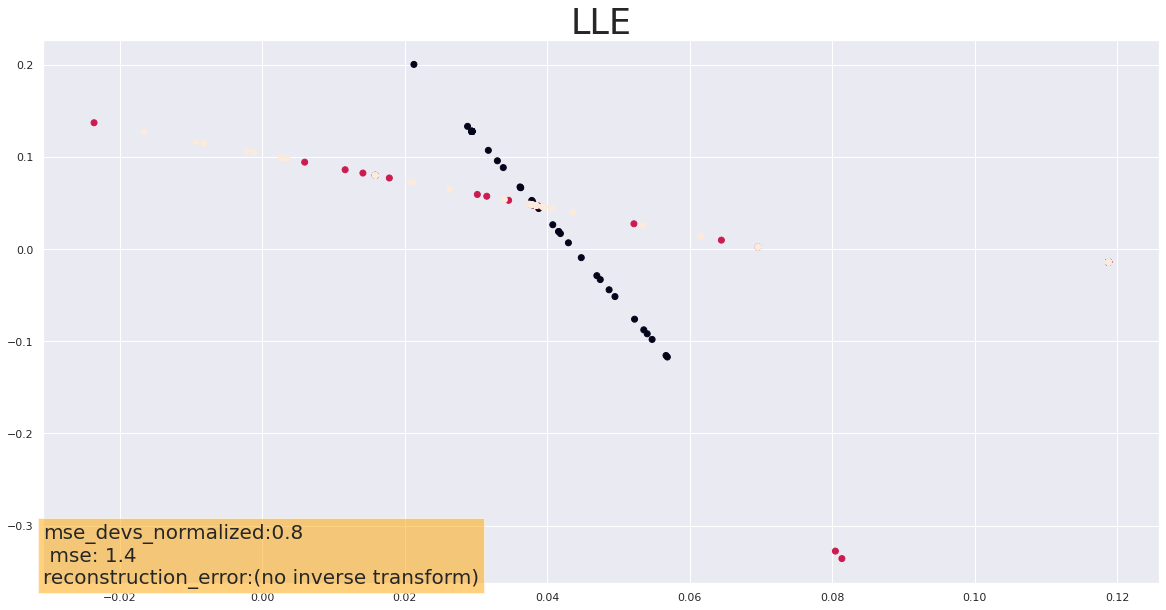

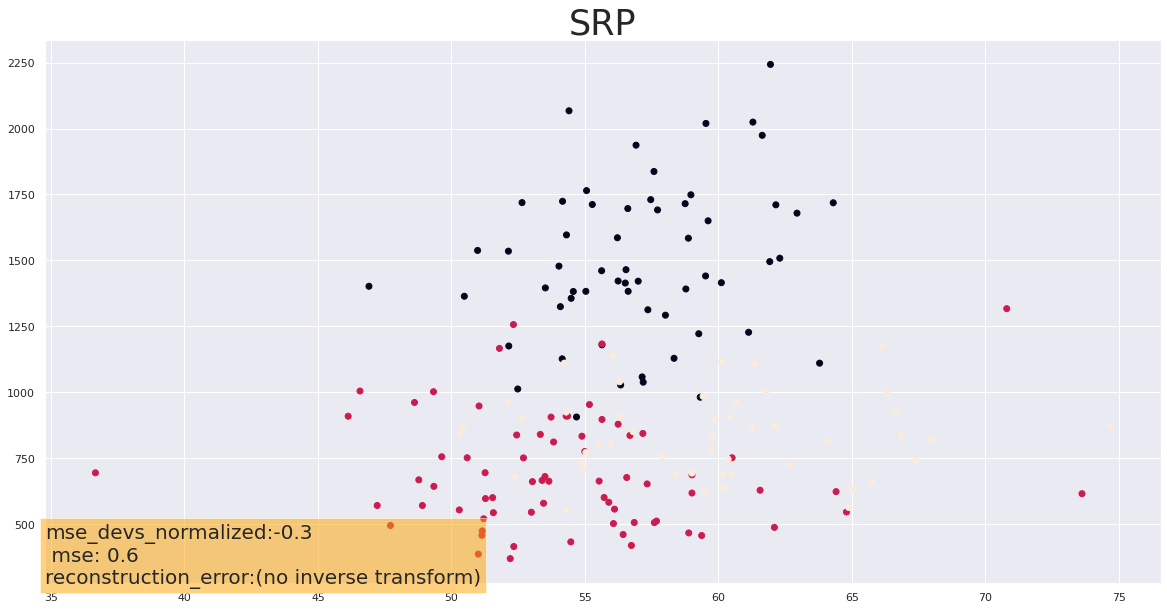

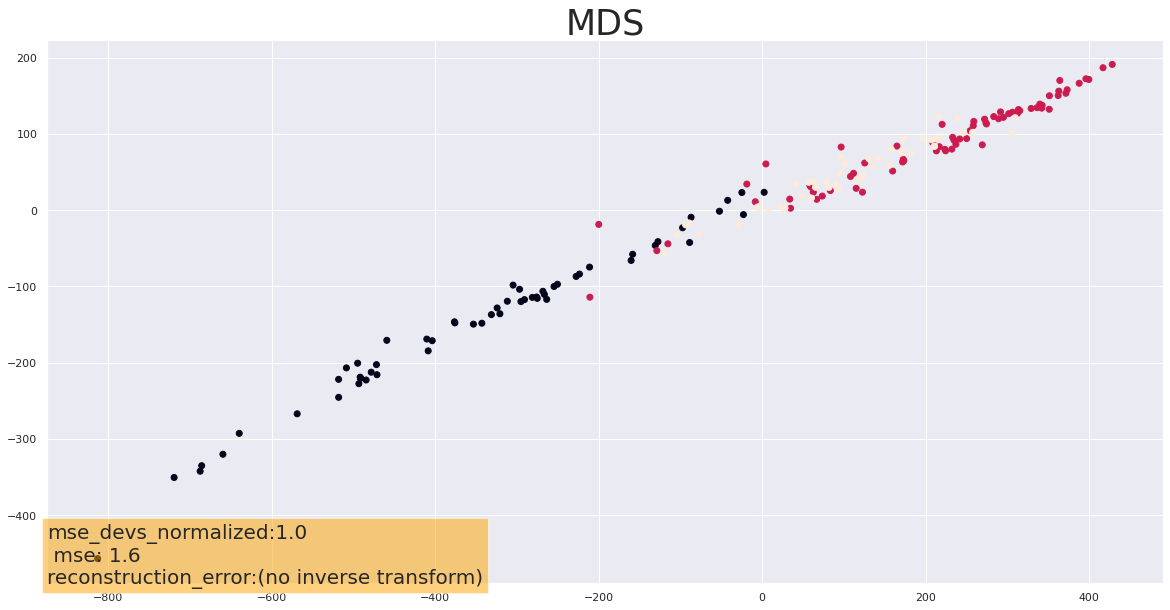

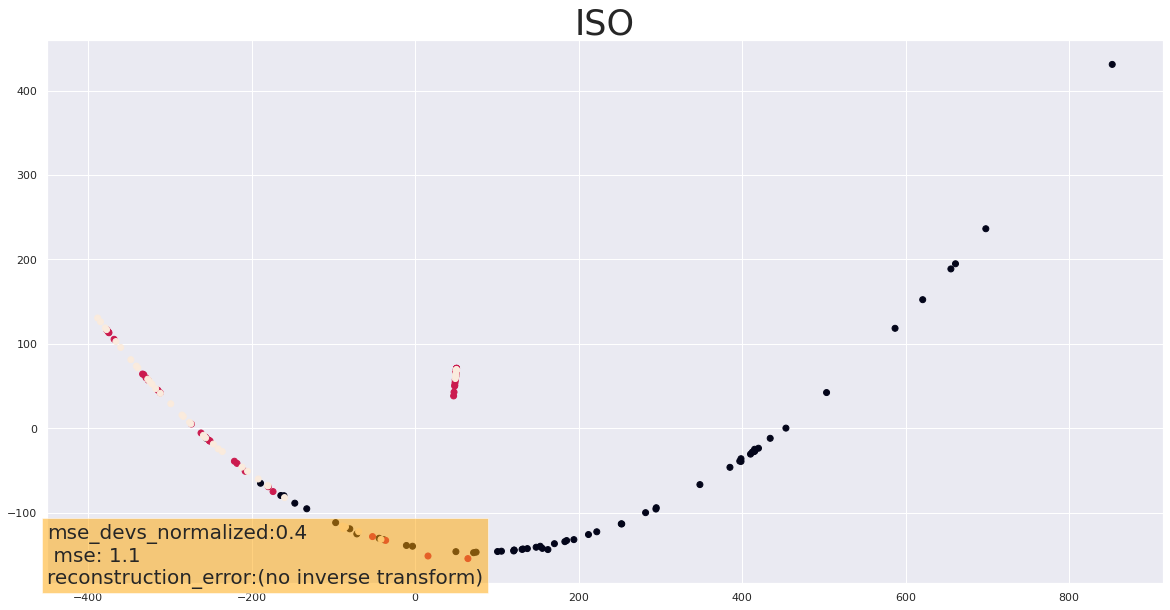

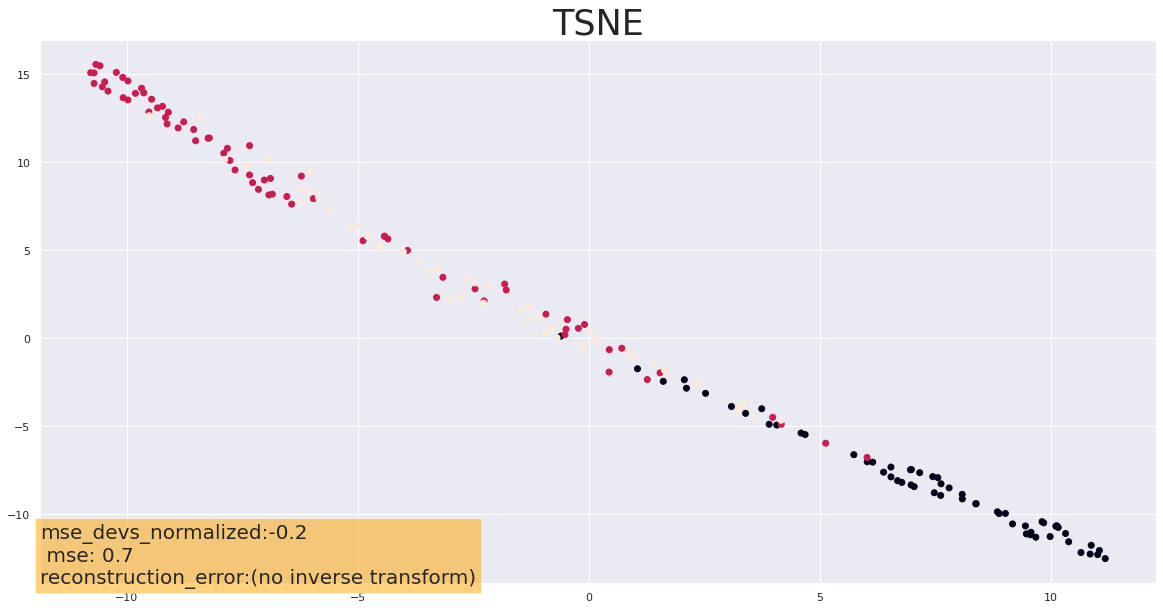

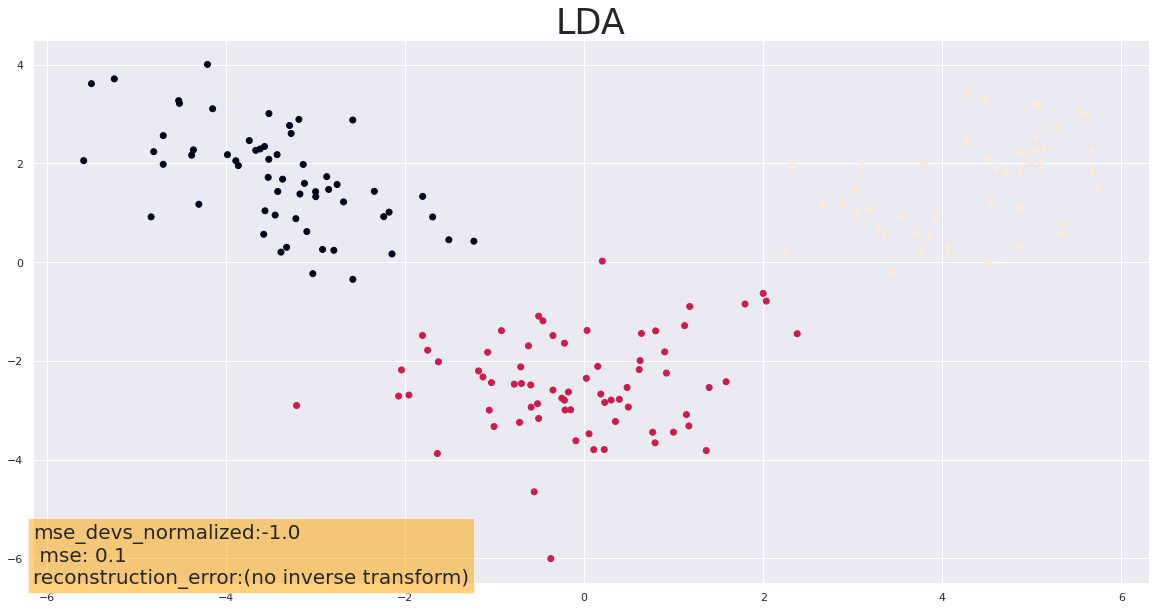

In [2]:
#begin plotting~~~~~~~~

#plotting
for i in range(n_algs):
    fig = plt.figure(figsize=(20,10))
    ax = plt.axes()
    ax.scatter(Xs_3d[i][:,0], Xs_3d[i][:,1], c=y)

    name = list(dim_reduce_algs.keys())[i]
    ax.set_title(name.upper(), fontsize=35)

    m1_text = 'reconstruction_error:'
    if np.isnan(metrics['reconstruction_error'][i]) : 
	    m1_text += '(no inverse transform)'
    else:
        m1_text += str(np.round(metrics['reconstruction_error'][i],1))

    m2_text = ' mse: ' +str(np.round(metrics['mse'][i],1))
    m3_text = 'mse_devs_normalized:' +str(np.round(metrics['mse_devs_normalized'][i],1)) #mse deviations normalized to [-1,1] )
    ax.text(0,0, m3_text +'\n'+ m2_text +'\n'+ m1_text, transform = ax.transAxes,fontsize=20, bbox={"facecolor":"orange", "alpha":0.5, "pad":5})

#end plotting~~~~~
